# Importing the necessary libraries

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
import cv2
import os

2023-07-15 21:01:12.512240: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-15 21:01:12.545595: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-15 21:01:12.688545: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-15 21:01:12.689317: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-15 21:01:13.391158: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

# Dataset description

> The dataset is organized into 3 folders (train, test, val) and contains subfolders for each image category (Pneumonia/Normal). There are 5,863 X-Ray images (JPEG) and 2 categories (Pneumonia/Normal).
Chest X-ray images (anterior-posterior) were selected from retrospective cohorts of pediatric patients of one to five years old from Guangzhou Women and Children’s Medical Center, Guangzhou. All chest X-ray imaging was performed as part of patients’ routine clinical care. For the analysis of chest x-ray images, all chest radiographs were initially screened for quality control by removing all low quality or unreadable scans. The diagnoses for the images were then graded by two expert physicians before being cleared for training the AI system. In order to account for any grading errors, the evaluation set was also checked by a third expert.

In [2]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150
def get_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size))     # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

# Loading the Dataset

In [3]:
train = get_data('chest_xray/chest_xray/train')
test = get_data('chest_xray/chest_xray/test')
val = get_data('chest_xray/chest_xray/val')

OpenCV(4.7.0) /io/opencv/modules/imgproc/src/resize.cpp:4062: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.7.0) /io/opencv/modules/imgproc/src/resize.cpp:4062: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



/tmp/ipykernel_53915/3742747629.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


OpenCV(4.7.0) /io/opencv/modules/imgproc/src/resize.cpp:4062: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.7.0) /io/opencv/modules/imgproc/src/resize.cpp:4062: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



# Data Visualization & Preprocessing

**Let's check out the dataset we're working on by picking out two data points from the dataset.**

In [4]:
pneumonia = os.listdir("chest_xray/train/PNEUMONIA")
pneumonia_dir = "chest_xray/train/PNEUMONIA"

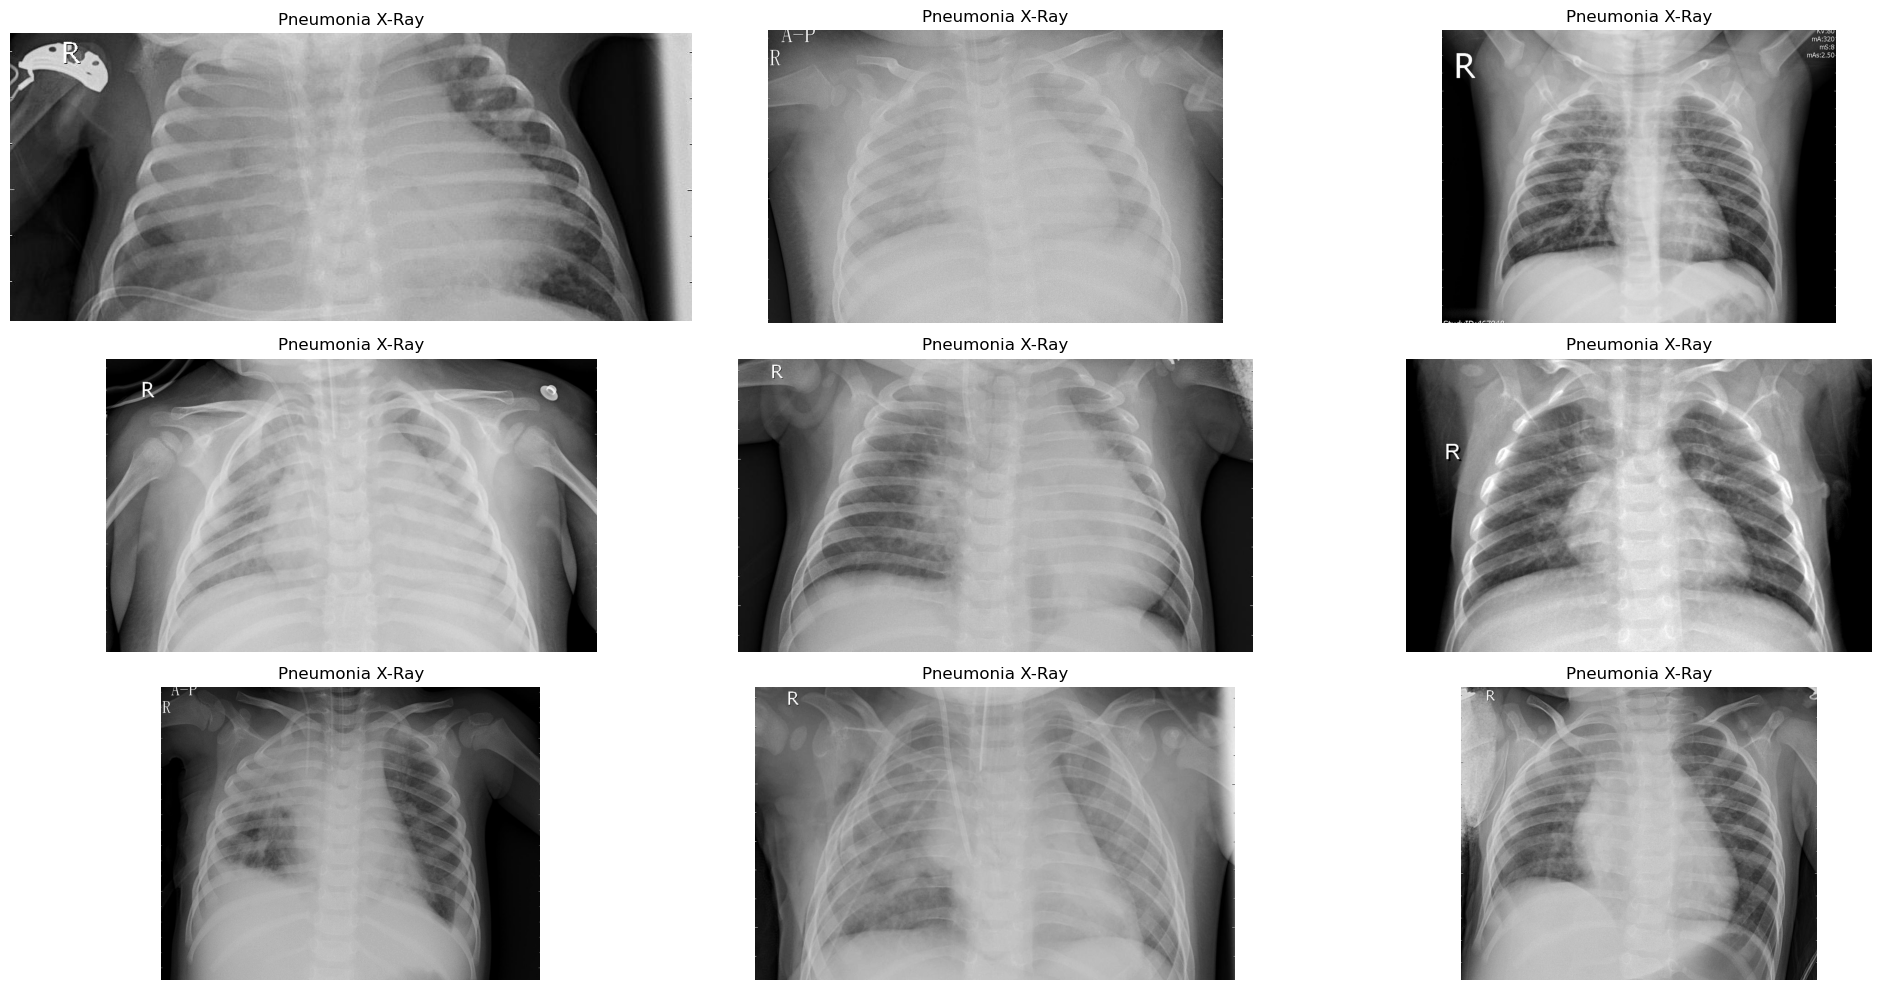

In [5]:
plt.figure(figsize=(20, 10))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = plt.imread(os.path.join(pneumonia_dir, pneumonia[i]))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title("Pneumonia X-Ray") 
plt.tight_layout()

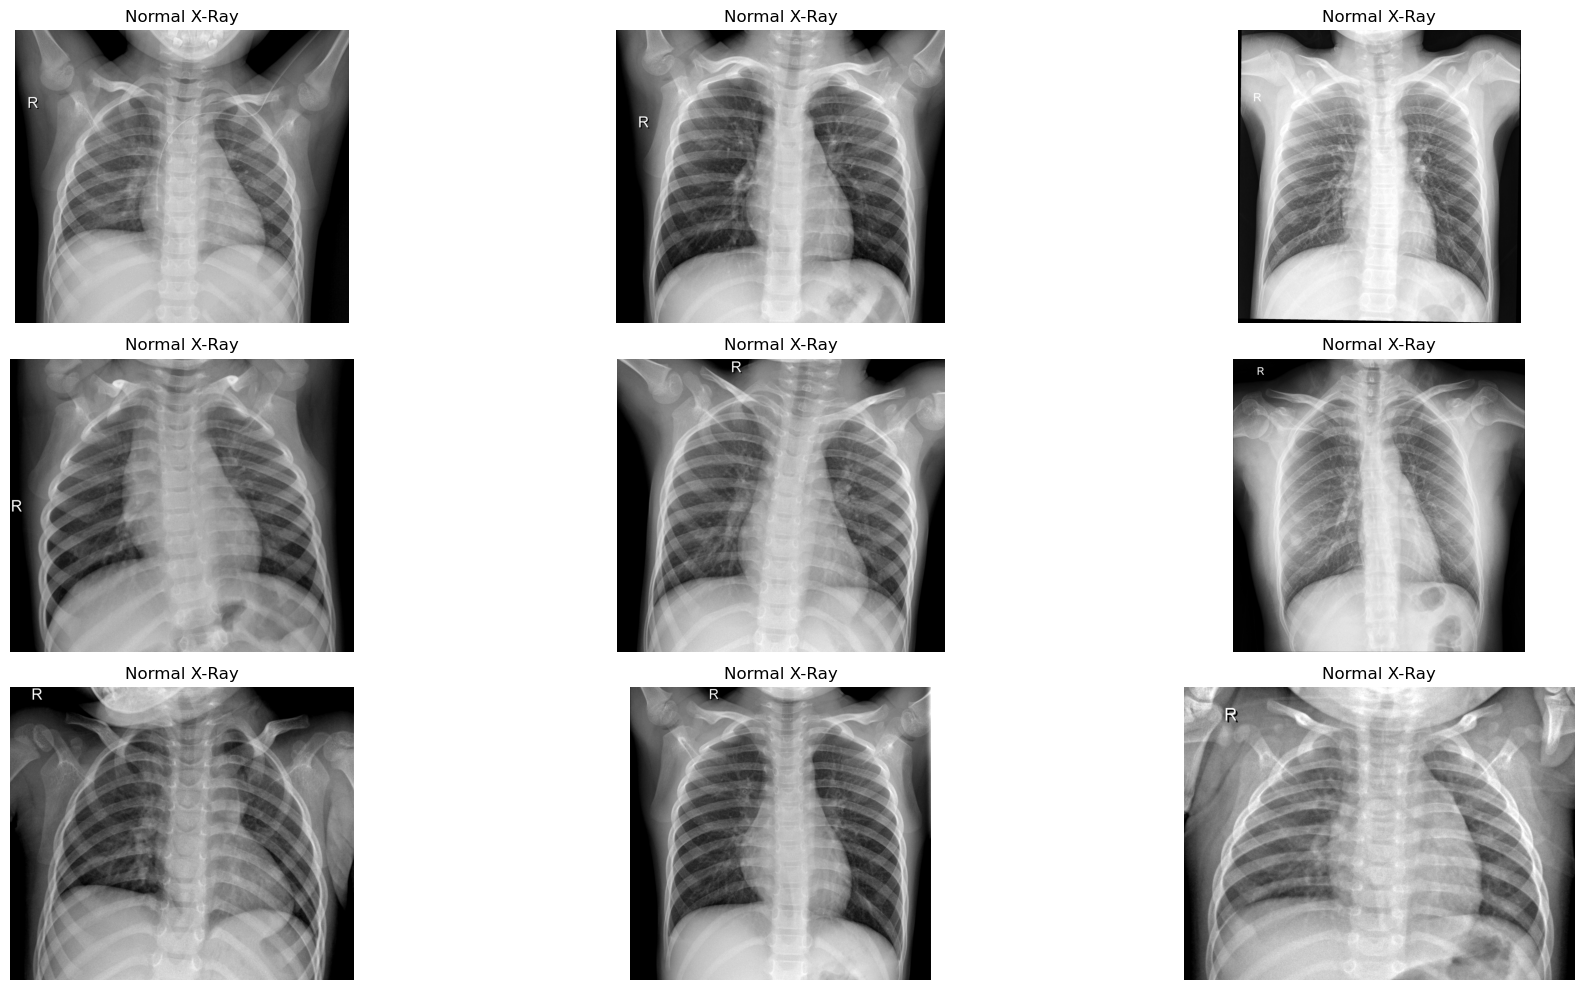

In [6]:
normal = os.listdir("chest_xray/train/NORMAL")
normal_dir = "chest_xray/train/NORMAL"

plt.figure(figsize=(20, 10))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = plt.imread(os.path.join(normal_dir, normal[i]))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title("Normal X-Ray") 
   
plt.tight_layout()

**Let's check out the number of data points we are working with in the dataset.**

In [7]:
list = []
for i in train:
    if(i[1] == 0):
        list.append("Pneumonia")
    else:
        list.append("Normal")
sns.set_style('darkgrid')
# sns.countplot(1)     

**The data seems imbalanced . To increase the no. of training examples, we will use data augmentation**

# Previewing the images of both the classes

Text(0.5, 1.0, 'NORMAL')

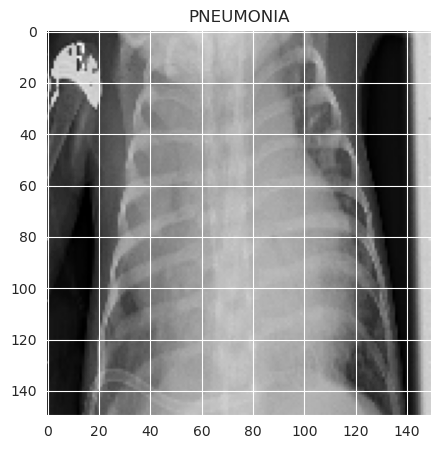

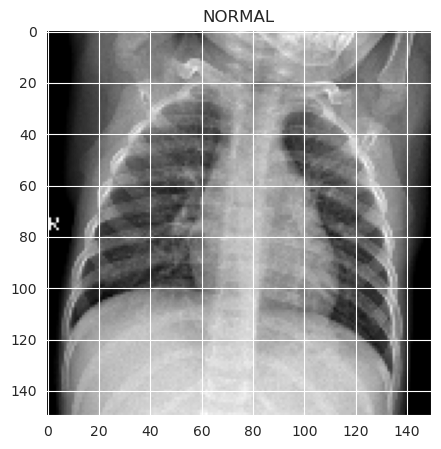

In [8]:
plt.figure(figsize = (5,5))
plt.imshow(train[0][0], cmap='gray')
plt.title(labels[train[0][1]])

plt.figure(figsize = (5,5))
plt.imshow(train[-1][0], cmap='gray')
plt.title(labels[train[-1][1]])

**Next, we perform some Data Preprocessing and Data Augmentation before we can proceed with building the model.**

In [9]:
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)
    
for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

**We perform a grayscale normalization to reduce the effect of illumination's differences.Moreover the CNN converges faster on [0..1] data than on [0..255].**

### **Normalizing the data**

In [10]:
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

# resize data for deep learning 
x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

# Data Augmentation
**In order to avoid overfitting problem, we need to expand artificially our dataset. We can make your existing dataset even larger. The idea is to alter the training data with small transformations to reproduce the variations.
Approaches that alter the training data in ways that change the array representation while keeping the label the same are known as data augmentation techniques. Some popular augmentations people use are grayscales, horizontal flips, vertical flips, random crops, color jitters, translations, rotations, and much more.
By applying just a couple of these transformations to our training data, we can easily double or triple the number of training examples and create a very robust model.**

For the data augmentation, i choosed to :
1. Randomly rotate some training images by 30 degrees 
2. Randomly Zoom by 20% some training images
3. Randomly shift images horizontally by 10% of the width 
4. Randomly shift images vertically by 10% of the height 
5. Randomly flip images horizontally.
Once our model is ready, we fit the training dataset.

In [11]:
# With data augmentation to prevent overfitting and handling the imbalance in dataset

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

# Training the Model

**Basic Structure of CNN**

In [19]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPool2D, Dropout, Flatten, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# Define the input shape
input_shape = (150, 150, 1)
input_layer = Input(shape=input_shape)
 
    
model = tf.keras.models.Sequential()

# First convolution.
model.add(tf.keras.layers.Convolution2D(
    input_shape=input_shape,
    filters=10,
    kernel_size=3,
    activation=tf.keras.activations.relu,
    name ='conv1'
))

model.add(tf.keras.layers.MaxPooling2D(
    pool_size=(2, 2),
    strides=(2, 2),
    name ='pool1'
))
model.add(tf.keras.layers.Convolution2D(
 
    filters=18,
    kernel_size=3,
    activation=tf.keras.activations.relu,
    name ='conv2'
))

    
model.add(Dropout(0.1) )
model.add(tf.keras.layers.MaxPooling2D(
    pool_size=(2, 2),
    strides=(2, 2),
    name ='pool2'
))  
model.add(tf.keras.layers.Convolution2D(
     
    filters=12,
    kernel_size=3,
    activation=tf.keras.activations.relu,
    name ='conv3'
))

model.add(tf.keras.layers.MaxPooling2D(
    pool_size=(2, 2),
    strides=(2, 2),
    name ='pool3'
))       
model.add(tf.keras.layers.Convolution2D(
 
    filters=8,
    kernel_size=3,
    activation=tf.keras.activations.relu,
    name ='conv4'
))
    
model.add(Dropout(0.2) )
model.add(tf.keras.layers.MaxPooling2D(
    pool_size=(2, 2),
    strides=(2, 2),
    name ='pool4'
))             
model.add(tf.keras.layers.Convolution2D(
 
    filters=12,
    kernel_size=3,
    activation=tf.keras.activations.relu,
    name ='conv5'
))
    
model.add(Dropout(0.8) )
model.add(tf.keras.layers.MaxPooling2D(
    pool_size=(2, 2),
    strides=(2, 2),
    name ='pool5'
))             
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(
    units=12,
    activation=tf.keras.activations.relu,
    name ='dense1'
))

 
          
model.add(tf.keras.layers.Dropout(0.5))    
# Output layer.
model.add(tf.keras.layers.Dense(
    units=1,
    activation=tf.keras.activations.sigmoid,
    name ='output'
))          
                   
          
          
#x = Conv2D(10, (3, 3), strides=1, padding='same', activation='relu', name ='conv1')(input_layer)
#x = BatchNormalization()(x)
#x = MaxPool2D((2, 2), strides=2, padding='same', name ='pool1')(x)
#x = Conv2D(18, (3, 3), strides=1, padding='same', activation='relu',name ='conv2')(x)
#x = Dropout(0.1)(x)
#x = BatchNormalization()(x)
#x = MaxPool2D((2, 2), strides=2, padding='same',name ='pool2')(x)

# x = Conv2D(15, (3, 3), strides=1, padding='same', activation='relu',name ='conv3')(x)
# x = BatchNormalization()(x)
# x = MaxPool2D((2, 2), strides=2, padding='same',name ='pool3')(x)

# x = Conv2D(8, (3, 3), strides=1, padding='same', activation='relu',name ='conv4')(x)
# x = Dropout(0.2)(x)
# x = BatchNormalization()(x)
# x = MaxPool2D((2, 2), strides=2, padding='same',name ='pool4')(x)

# x = Conv2D(12, (3, 3), strides=1, padding='same', activation='relu',name ='conv5')(x)
# x = Dropout(0.8)(x)
# x = BatchNormalization()(x)
# x = MaxPool2D((2, 2), strides=2, padding='same',name ='pool5')(x)

# x = Flatten()(x)
# x = Dense(units=10, activation='relu', name  = 'dense')(x)
# x = Dropout(0.2)(x)
# x = Dense(units=1, activation='sigmoid' , name = 'output')(x)

 
# model = Model(inputs=input_layer, outputs=[x])
 
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

 
model.summary()
################################################################################################################qkeras
 
import tensorflow as tf
from qkeras import *
from qkeras import QActivation
from qkeras import QDense
from qkeras import QConv2D

input_shape =  (150, 150, 1)
x = QConv2DBatchnorm(
kernel_size=3,
filters=10,
kernel_quantizer="quantized_bits(6,0,alpha=1)",
bias_quantizer="quantized_bits(6,0,alpha=1)",
kernel_initializer='lecun_uniform',
name="conv2d_1")(input_layer)

x = QActivation("quantized_relu(6)", name="act0")(x)

x = tf.keras.layers.MaxPooling2D(
    pool_size=(2, 2),
    strides=(2, 2),
    name='maxpool_1'
)(x)

x = QConv2DBatchnorm(
kernel_size=3,
filters=18,
kernel_quantizer="quantized_bits(6,0,alpha=1)",
bias_quantizer="quantized_bits(6,0,alpha=1)",
kernel_initializer='lecun_uniform',
name="conv2")(x)

x = QActivation("quantized_relu(6)", name="act2")(x)
x = tf.keras.layers.Dropout(0.1)(x)

x = tf.keras.layers.MaxPooling2D(
    pool_size=(2, 2),
    strides=(2, 2),
    name='maxpool_2'
)(x)

x = QConv2DBatchnorm(
kernel_size=3,
filters=12,
kernel_quantizer="quantized_bits(6,0,alpha=1)",
bias_quantizer="quantized_bits(6,0,alpha=1)",
kernel_initializer='lecun_uniform',
name="conv3")(x)

x = QActivation("quantized_relu(6)", name="act3")(x)

x = tf.keras.layers.MaxPooling2D(
    pool_size=(2, 2),
    strides=(2, 2),
    name='maxpool_3'
)(x)

x = QConv2DBatchnorm(
kernel_size=3,
filters=8,
kernel_quantizer="quantized_bits(6,0,alpha=1)",
bias_quantizer="quantized_bits(6,0,alpha=1)",
kernel_initializer='lecun_uniform',
name="conv4")(x)

x = QActivation("quantized_relu(6)", name="act4")(x)


x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.MaxPooling2D(
    pool_size=(2, 2),
    strides=(2, 2),
    name='maxpool_4'
)(x)

x = QConv2DBatchnorm(
kernel_size=3,
filters=12,
kernel_quantizer="quantized_bits(6,0,alpha=1)",
bias_quantizer="quantized_bits(6,0,alpha=1)",
kernel_initializer='lecun_uniform',
name="conv5")(x)


x = QActivation("quantized_relu(6)", name="act5")(x) 


x = tf.keras.layers.Dropout(0.8)(x)
x = tf.keras.layers.MaxPooling2D(
    pool_size=(2, 2),
    strides=(2, 2),
    name='maxpool_4'
)(x)
x = tf.keras.layers.Flatten()(x)
x = QDense(
    12,
    kernel_quantizer="quantized_bits(6,0,alpha=1)",
    kernel_initializer='lecun_uniform',
  
    name="dense1")(
        x)

x = QActivation("quantized_relu(6)", name="act6")(x)  


x = tf.keras.layers.Dropout(0.5)(x)

x = QDense(
    units=1,
    kernel_quantizer=quantized_bits(6, 0, 0),
    bias_quantizer=quantized_bits(6, 0, 0),
    name="dense2")(
        x)
x = Activation("sigmoid", name="output")(x)


model = tf.keras.Model(inputs=input_layer, outputs=[x])


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 148, 148, 10)      100       
                                                                 
 pool1 (MaxPooling2D)        (None, 74, 74, 10)        0         
                                                                 
 conv2 (Conv2D)              (None, 72, 72, 18)        1638      
                                                                 
 dropout_15 (Dropout)        (None, 72, 72, 18)        0         
                                                                 
 pool2 (MaxPooling2D)        (None, 36, 36, 18)        0         
                                                                 
 conv3 (Conv2D)              (None, 34, 34, 12)        1956      
                                                                 
 pool3 (MaxPooling2D)        (None, 17, 17, 12)       

In [20]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

In [21]:
history = model.fit(datagen.flow(x_train,y_train, batch_size = 64) ,epochs = 10 , validation_data = datagen.flow(x_val, y_val) ,callbacks = [learning_rate_reduction])

Epoch 1/10


2023-07-15 21:23:18.341004: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


82/82 [==============================] - 10s 115ms/step - loss: 0.6395 - accuracy: 0.6710 - val_loss: 0.7016 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/10


2023-07-15 21:23:28.192958: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


82/82 [==============================] - 9s 109ms/step - loss: 0.5973 - accuracy: 0.7345 - val_loss: 0.7090 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 3/10
82/82 [==============================] - ETA: 0s - loss: 0.5313 - accuracy: 0.7483
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
82/82 [==============================] - 9s 113ms/step - loss: 0.5313 - accuracy: 0.7483 - val_loss: 0.6885 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 4/10
82/82 [==============================] - 10s 123ms/step - loss: 0.4603 - accuracy: 0.7826 - val_loss: 0.7001 - val_accuracy: 0.5000 - lr: 3.0000e-04
Epoch 5/10
82/82 [==============================] - ETA: 0s - loss: 0.4363 - accuracy: 0.8004
Epoch 5: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
82/82 [==============================] - 9s 112ms/step - loss: 0.4363 - accuracy: 0.8004 - val_loss: 0.7181 - val_accuracy: 0.5000 - lr: 3.0000e-04
Epoch 6/10
82/82 [==============================] - 9s 113ms/ste

In [22]:
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

20/20 [==============================] - 0s 13ms/step - loss: 0.5394 - accuracy: 0.6923
Loss of the model is -  0.5393730401992798
20/20 [==============================] - 0s 12ms/step - loss: 0.5394 - accuracy: 0.6923
Accuracy of the model is -  69.2307710647583 %


#  HLS for ML


In [23]:
model.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 148, 148, 10)      100       
                                                                 
 pool1 (MaxPooling2D)        (None, 74, 74, 10)        0         
                                                                 
 conv2 (Conv2D)              (None, 72, 72, 18)        1638      
                                                                 
 dropout_15 (Dropout)        (None, 72, 72, 18)        0         
                                                                 
 pool2 (MaxPooling2D)        (None, 36, 36, 18)        0         
                                                                 
 conv3 (Conv2D)              (None, 34, 34, 12)        1956      
                                                                 
 pool3 (MaxPooling2D)        (None, 17, 17, 12)       

In [24]:
import hls4ml

 

hls_config = hls4ml.utils.config_from_keras_model(model, granularity='name')
hls_config['Model']['ReuseFactor'] = 2584
hls_config['LayerName']['conv1']['Strategy'] = 'Latency'
hls_config['LayerName']['conv2']['Strategy'] = 'Latency'
hls_config['LayerName']['conv3']['Strategy'] = 'Latency'
hls_config['LayerName']['conv4']['Strategy'] = 'Latency'
hls_config['LayerName']['pool1']['Strategy'] = 'Latency'
hls_config['LayerName']['pool2']['Strategy'] = 'Latency'
hls_config['LayerName']['pool3']['Strategy'] = 'Latency'
hls_config['LayerName']['pool4']['Strategy'] = 'Latency'
hls_config['LayerName']['conv5']['Strategy'] = 'Latency'
hls_config['LayerName']['dense1']['Strategy'] = 'Latency' 
hls_config['Model']['Precision'] = 'ap_fixed<8,2>'
hls_config['LayerName']['output']['Strategy'] = 'Stable'
#plotting.print_dict(hls_config_aq)

hls_config['Flows'] = ['vivado:fifo_depth_optimization']
hls4ml.model.optimizer.get_optimizer('vivado:fifo_depth_optimization').configure(profiling_fifo_depth=100)
cfg = hls4ml.converters.create_config(backend='Vivado')
cfg['IOType'] = 'io_stream'  # Must set this if using CNNs!
cfg['HLSConfig'] = hls_config
cfg['KerasModel'] = model
cfg['OutputDir'] = 'normal_cnn/'
cfg['Part'] = 'xczu7ev-ffvc1156-2-e'

hls_model = hls4ml.converters.keras_to_hls(cfg)
 
 

print("----------------compilation starts-------------------")
hls_model.compile()
# X_test = np.ascontiguousarray(x_test_normalized)
# y_hls = hls_model.predict(X_test)
print("----------------compilation done-------------------")

 


Interpreting Sequential
Topology:
Layer name: conv1_input, layer type: InputLayer, input shapes: [[None, 150, 150, 1]], output shape: [None, 150, 150, 1]
Layer name: conv1, layer type: Conv2D, input shapes: [[None, 150, 150, 1]], output shape: [None, 148, 148, 10]
Layer name: pool1, layer type: MaxPooling2D, input shapes: [[None, 148, 148, 10]], output shape: [None, 74, 74, 10]
Layer name: conv2, layer type: Conv2D, input shapes: [[None, 74, 74, 10]], output shape: [None, 72, 72, 18]
Layer name: pool2, layer type: MaxPooling2D, input shapes: [[None, 72, 72, 18]], output shape: [None, 36, 36, 18]
Layer name: conv3, layer type: Conv2D, input shapes: [[None, 36, 36, 18]], output shape: [None, 34, 34, 12]
Layer name: pool3, layer type: MaxPooling2D, input shapes: [[None, 34, 34, 12]], output shape: [None, 17, 17, 12]
Layer name: conv4, layer type: Conv2D, input shapes: [[None, 17, 17, 12]], output shape: [None, 15, 15, 8]
Layer name: pool4, layer type: MaxPooling2D, input shapes: [[None, 1

FileNotFoundError: [Errno 2] No such file or directory: 'normal_cnn//myproject_prj/solution1/sim/verilog/fifo_opt.vcd'

In [73]:
# x_test_normalized = x_test / 255

In [ ]:


# X_test = np.ascontiguousarray(x_test_normalized)  
y_predict_hls4ml = hls_model.predict( x_test)
 

In [29]:
hls_model.build(csim=False, synth=True, vsynth=True)


****** Vivado(TM) HLS - High-Level Synthesis from C, C++ and SystemC v2019.2 (64-bit)
  **** SW Build 2708876 on Wed Nov  6 21:39:14 MST 2019
  **** IP Build 2700528 on Thu Nov  7 00:09:20 MST 2019
    ** Copyright 1986-2019 Xilinx, Inc. All Rights Reserved.

source /home/ayush/vivado_2019/Vivado/2019.2/scripts/vivado_hls/hls.tcl -notrace
INFO: [HLS 200-10] Running '/home/ayush/vivado_2019/Vivado/2019.2/bin/unwrapped/lnx64.o/vivado_hls'
INFO: [HLS 200-10] For user 'ayush' on host 'binodssd' (Linux_x86_64 version 5.19.0-45-generic) on Sat Jul 15 20:37:50 IST 2023
INFO: [HLS 200-10] On os Ubuntu 22.04.2 LTS
INFO: [HLS 200-10] In directory '/home/ayush/lasthls4ml/pneumonia_tf/normal_cnn'
Sourcing Tcl script 'build_prj.tcl'
INFO: [HLS 200-10] Opening project '/home/ayush/lasthls4ml/pneumonia_tf/normal_cnn/myproject_prj'.
INFO: [HLS 200-10] Adding design file 'firmware/myproject.cpp' to the project
INFO: [HLS 200-10] Adding test bench file 'myproject_test.cpp' to the project
INFO: [HLS 200

{'CSimResults': [],
 'CSynthesisReport': {'TargetClockPeriod': '5.00',
  'EstimatedClockPeriod': '4.339',
  'BestLatency': '22541',
  'WorstLatency': '22541',
  'IntervalMin': '22503',
  'IntervalMax': '22503',
  'BRAM_18K': '898',
  'DSP': '4466',
  'FF': '76962',
  'LUT': '273071',
  'URAM': '0',
  'AvailableBRAM_18K': '624',
  'AvailableDSP': '1728',
  'AvailableFF': '460800',
  'AvailableLUT': '230400',
  'AvailableURAM': '96'},
 'VivadoSynthReport': {'LUT': '301719',
  'FF': '50415',
  'BRAM_18K': '310',
  'URAM': '0',
  'DSP48E': '1728'}}

In [ ]:
epochs = [i for i in range(12)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()

# Predictions

In [ ]:
predictions = model.predict_classes(x_test)
predictions = predictions.reshape(1,-1)[0]
predictions[:15]

In [ ]:
print(classification_report(y_test, predictions, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

In [ ]:
cm = confusion_matrix(y_test,predictions)
cm

In [ ]:
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])

In [ ]:
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)

In [ ]:
correct = np.nonzero(predictions == y_test)[0]
incorrect = np.nonzero(predictions != y_test)[0]

**Some of the Correctly Predicted Classes**

In [ ]:
i = 0
for c in correct[:6]:
    plt.subplot(4,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c].reshape(150,150), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y_test[c]))
    plt.tight_layout()
    i += 1

**Some of the Incorrectly Predicted Classes**

In [27]:
i = 0
for c in incorrect[:6]:
    plt.subplot(4,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c].reshape(150,150), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y_test[c]))
    plt.tight_layout()
    i += 1

NameError: name 'incorrect' is not defined

In [28]:
#model.save(../model.h5)

In [41]:

from tensorflow_model_optimization.quantization.keras import vitis_quantize

In [43]:
quantizer = vitis_quantize.VitisQuantizer(model)
quantized_model = quantizer.quantize_model(calib_dataset = x_test, weight_bit=8, activation_bit=8)

quantized_model.compile(loss='categorical_crossentropy', metrics=["accuracy"])

score = quantized_model.evaluate(x_test,y_test ,verbose=0, batch_size=1)
print(score)
print('last')
quantized_model.save('pneumonia.h5')

[VAI INFO] Update activation_bit: 8
[VAI INFO] Update weight_bit: 8
[VAI INFO] Start CrossLayerEqualization...
10/10 [==============================] - 2s 184ms/step
[VAI INFO] CrossLayerEqualization Done.
[VAI INFO] Start Quantize Calibration...
20/20 [==============================] - 19s 726ms/step
[VAI INFO] Quantize Calibration Done.
[VAI INFO] Start Post-Quant Model Refinement...
[VAI INFO] Start Quantize Position Ajustment...
[VAI INFO] Quantize Position Ajustment Done.
[VAI INFO] Post-Quant Model Refninement Done.
[VAI INFO] Start Model Finalization...
[VAI INFO] Model Finalization Done.
[VAI INFO] Quantization Finished.
[nan, 0.625]
last
